In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
import sys

In [2]:
def ldaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix 
    
    # IMPLEMENT THIS METHOD
    
    class_list = np.unique(y)  # Creating a unique class list with size of 1 * d
    
    # Create an empty d * k matrix for means
    means = np.zeros((X.shape[1], class_list.shape[0]))
    
    # Put all the mean column vector into means matrix
    j = 0
    for i in class_list:     # Iterate the class list
        location = np.where(y == i)[0]   # Find row indexes for a specific class
        mean = np.mean(X[location], axis=0)
        means[:, j] = mean.transpose()
        j = j + 1

    # Calculate the mean of every column for means matrix
    ground_mean = np.mean(X, axis=0)

    # Calculate the covariance matrix of X
    covmat = np.cov((X - ground_mean).transpose())
    
    return means,covmat


In [3]:
def qdaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes
    
    # IMPLEMENT THIS METHOD
    
    class_list = np.unique(y)  # Creating a unique class list

    # Create an empty d*k matrix for means. And it is the same as LDA
    means = np.zeros((X.shape[1], class_list.shape[0]))

    j = 0
    covmats = []

    for i in class_list.transpose():
        location2 = np.where(y == i)[0]
        mean2 = np.mean(X[location2], axis=0)
        means[:, j] = mean2.transpose()
        dif = X[location2, ] - mean2
        covmats.append(np.cov(dif.transpose()))
        j = j + 1

    return means,covmats

In [4]:
def ldaTest(means,covmat,Xtest,ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    
    # Create a new empty matrix with N*k size
    result_p = np.zeros((Xtest.shape[0], means.shape[1]))

    # prior probability
    p = 1/np.sqrt((2*pi) ** means.shape[0] * det(covmat))

    # Calculate probabilities of every Xi for every y
    j = 0
    for i in means.transpose():
        mean = i
        Prob = p * np.exp(- 0.5 * np.sum([a * b for a, b in zip(np.dot(Xtest - mean, inv(covmat)), Xtest - mean)], axis=1))
        result_p[:, j] = Prob
        j = j + 1

    ypred = np.argmax(result_p, axis=1) + 1
    error = ypred - ytest.ravel()
    acc = (Xtest.shape[0] - float(len(np.nonzero(error)[0])))/Xtest.shape[0]

    return acc,ypred

In [5]:
def qdaTest(means,covmats,Xtest,ytest):
    # Inputs
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    
    # Create a new empty matrix with N*k size
    result_p2 = np.zeros((Xtest.shape[0], means.shape[1]))

    j = 0
    for i in means.transpose():
        p = 1 / np.sqrt((2*pi) ** means.shape[0] * det(covmats[j]))
        mean = i

        Prob = p * np.exp(- 0.5 * np.sum([a * b for a, b in zip(np.dot(Xtest - mean, inv(covmats[j])), Xtest - mean)], axis=1))

        result_p2[:, j] = Prob
        j = j + 1

    ypred = np.argmax(result_p2, axis=1) + 1
    error = ypred - ytest.ravel()
    acc = (Xtest.shape[0] - float(len(np.nonzero(error)[0]))) / Xtest.shape[0]
    
    return acc,ypred

In [6]:
def learnOLERegression(X,y):
    # Inputs:                                                         
    # X = N x d 
    # y = N x 1                                                               
    # Output: 
    # w = d x 1 
	
    # IMPLEMENT THIS METHOD
    
    w = np.dot(np.dot(inv(np.dot(X.transpose(), X)), X.transpose()), y)
    return w

In [7]:
def learnRidgeRegression(X,y,lambd):
    # Inputs:
    # X = N x d                                                               
    # y = N x 1 
    # lambd = ridge parameter (scalar)
    # Output:                                                                  
    # w = d x 1                                                                

    # IMPLEMENT THIS METHOD 
    k = inv(lambd * np.identity(X.shape[1]) + np.dot(X.transpose(), X))
    w = np.dot(np.dot(k, X.transpose()), y)
    
    return w

In [8]:
def testOLERegression(w,Xtest,ytest):
    # Inputs:
    # w = d x 1
    # Xtest = N x d
    # ytest = X x 1
    # Output:
    # mse
    
    # IMPLEMENT THIS METHOD
    y_predict = np.dot(Xtest,w)
    error = ytest - y_predict
    mse = np.sum(np.dot(error.transpose(), error)) / float(Xtest.shape[0])
    
    return mse

In [19]:
def regressionObjVal(w, X, y, lambd):

    # compute squared error (scalar) and gradient of squared error with respect
    # to w (vector) for the given data X and y and the regularization parameter
    # lambda                                                                  

    # IMPLEMENT THIS METHOD
    
    d = X.shape[1]
    w_mat = np.reshape(w,(d,1))
    extra_term = y - np.dot(X,w_mat)
    
    error = 0.5*(np.dot(extra_term.transpose(),extra_term) + lambd*np.dot(w_mat.transpose(),w_mat))
    
    # xT (y-Xw) + lambda * w
    error_grad = -(np.dot(X.transpose(),extra_term)) + lambd*w_mat
    error_grad = np.squeeze(np.array(error_grad))
    
    return error, error_grad

In [10]:
def mapNonLinear(x,p):
    # Inputs:                                                                  
    # x - a single column vector (N x 1)                                       
    # p - integer (>= 0)                                                       
    # Outputs:                                                                 
    # Xp - (N x (p+1)) 
	
    # IMPLEMENT THIS METHOD
    
    N  = x.shape[0]
    d  = p + 1
    Xp = np.zeros((N,d))
    # Iterate every column and do power of x  with the index, generating 1,x,x^2,x^3... x^p
    for column in range(d):
        Xp[:,column] = pow(x,column)
    return Xp

In [11]:
# Main script

# Problem 1
# load the sample data                                                                 
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')

In [12]:
# LDA
means,covmat = ldaLearn(X,y)
ldaacc,ldares = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))

LDA Accuracy = 0.97


In [13]:
# QDA
means,covmats = qdaLearn(X,y)
qdaacc,qdares = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))

QDA Accuracy = 0.96


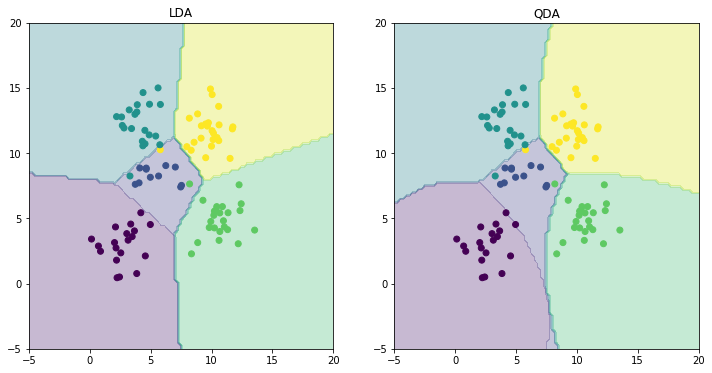

In [14]:
# plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0], Xtest[:,1],c=ytest[:,0])
plt.title('LDA')

plt.subplot(1, 2, 2)

zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest[:,0])
plt.title('QDA')

plt.show()

In [15]:
# Problem 2
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'),encoding = 'latin1')

# add intercept
X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)

w = learnOLERegression(X,y)
mse = testOLERegression(w, X, y)
mle = testOLERegression(w,Xtest,ytest)

w_i = learnOLERegression(X_i,y)
mse_i = testOLERegression(w_i, X_i, y)
mle_i = testOLERegression(w_i,Xtest_i,ytest)

print ("Linear regression MSE")
print ("without intercept:")
print ("  MSE for training data:" + str(mse))
print ("  MSE for test data: " +str(mle))
print ("with intercept")
print ("  MSE for training data:" +str(mse_i))
print ("  MSE for test data: " +str(mle))

Linear regression MSE
without intercept:
  MSE for training data:19099.446844570695
  MSE for test data: 106775.36155731279
with intercept
  MSE for training data:2187.160294930389
  MSE for test data: 106775.36155731279


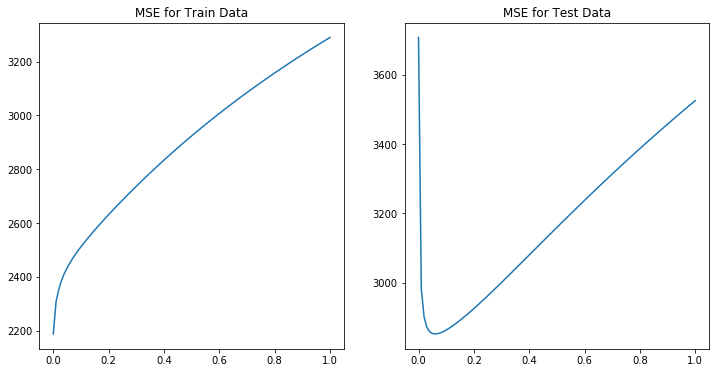

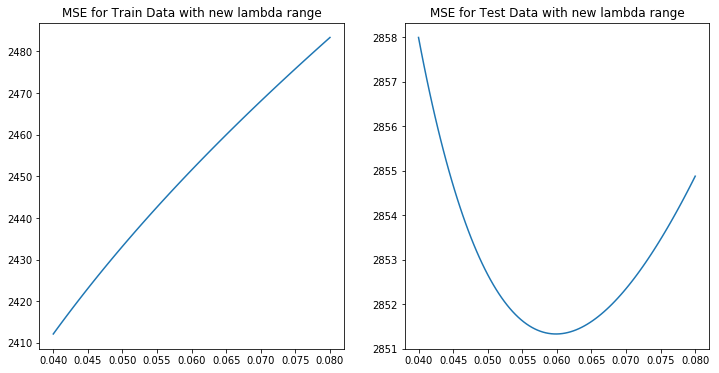

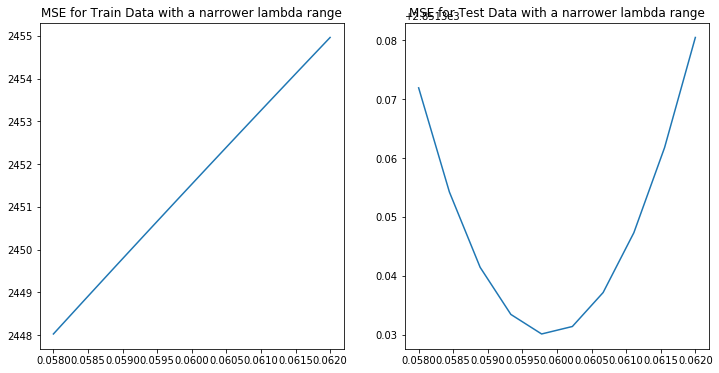

weight matrix for OLE:
[[ 1.48154876e+02  1.27485206e+00 -2.93383522e+02  4.14725448e+02
   2.72089134e+02 -8.66394570e+04  7.59144679e+04  3.23416228e+04
   2.21101215e+02  2.92995512e+04  1.25230360e+02  9.44110833e+01
  -9.38628633e+01 -3.37282800e+01  3.35319773e+03 -6.21096297e+02
   7.91736534e+02  1.76776039e+03  4.19167405e+03  1.19438121e+02
   7.66103400e+01 -1.52001293e+01  8.22424594e+01 -1.45666208e+03
   8.27386703e+02  8.69290952e+02  5.86234495e+02  4.27026727e+02
   9.02467690e+01 -1.78876224e+01  1.41696774e+02  5.82819384e+02
  -2.34037510e+02 -2.56071452e+02 -3.85177400e+02 -3.34176736e+01
  -1.07350066e+01  2.57107189e+02  5.99554593e+01  3.83728042e+02
  -4.04158390e+02 -5.14286434e+02  3.83636642e+01 -4.46102889e+01
  -7.29643529e+02  3.77408336e+02  4.39794290e+02  3.08514373e+02
   1.89859678e+02 -1.09773797e+02 -1.91965700e+03 -1.92463378e+03
  -3.48979528e+03  1.17969687e+04  5.30674415e+02  5.43305907e+02
   1.82107518e+03 -1.04639807e+04 -5.16627611e+02  2.

In [16]:
# Problem 3
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses3_train = np.zeros((k,1))
mses3 = np.zeros((k,1))
for lambd in lambdas:
    w_l = learnRidgeRegression(X_i,y,lambd)
    mses3_train[i] = testOLERegression(w_l,X_i,y)
    mses3[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.show()

# Try a new range to find the optimal lambda
k_new = 101
lambdas_new = np.linspace(0.04, 0.08, num=k_new)
i = 0
mses3_train_new = np.zeros((k_new,1))
mses3_new = np.zeros((k_new,1))
for lambd in lambdas_new:
    w_l_new = learnRidgeRegression(X_i,y,lambd)
    mses3_train_new[i] = testOLERegression(w_l_new,X_i,y)
    mses3_new[i] = testOLERegression(w_l_new,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas_new,mses3_train_new)
plt.title('MSE for Train Data with new lambda range')
plt.subplot(1, 2, 2)
plt.plot(lambdas_new,mses3_new)
plt.title('MSE for Test Data with new lambda range')
plt.show()

# Try a narrow range to find the optimal lambda
k_new2 = 10
lambdas_new2 = np.linspace(0.058, 0.062, num=k_new2)
i = 0
mses3_train_new2 = np.zeros((k_new2,1))
mses3_new2 = np.zeros((k_new2,1))
for lambd in lambdas_new2:
    w_l_new2 = learnRidgeRegression(X_i,y,lambd)
    mses3_train_new2[i] = testOLERegression(w_l_new2,X_i,y)
    mses3_new2[i] = testOLERegression(w_l_new2,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas_new2,mses3_train_new2)
plt.title('MSE for Train Data with a narrower lambda range')
plt.subplot(1, 2, 2)
plt.plot(lambdas_new2,mses3_new2)
plt.title('MSE for Test Data with a narrower lambda range')
plt.show()

print ("weight matrix for OLE:")
print (w_i.transpose())
print ("weight matrix for Ridge regression:")
print (learnRidgeRegression(X_i, y, 0.0598).transpose())

# For Analysis in Problem 6
mse3=mses3_train[np.argmin(mses3)]
mle3=mses3[np.argmin(mses3)]
print("\n")
print('Ridge Regression with lambda=0.0598')
print('  MSE for training data:'+str(mses3_train[np.argmin(mses3)]))
print('  MSE for test data:'+str(mses3[np.argmin(mses3)]))

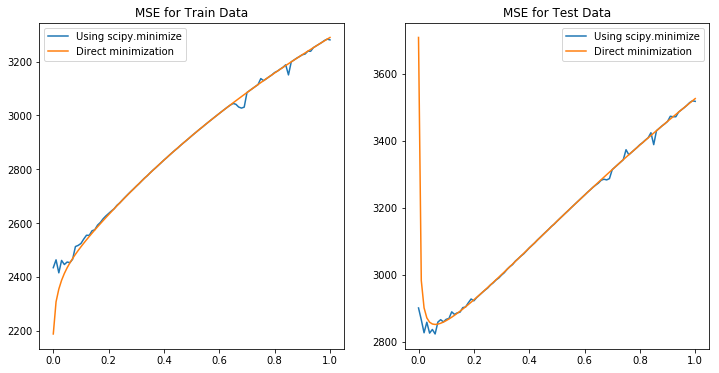

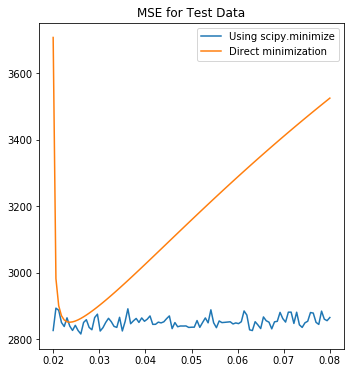

Gradient Descent for Ridge Regression with lamba =0.026
  MSE for training data:[2423.16942863]
  MSE for test data:[2816.0004691]


In [20]:
# Problem 4
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses4_train = np.zeros((k,1))
mses4 = np.zeros((k,1))
opts = {'maxiter' : 20}    # Preferred value.                                                
w_init = np.ones((X_i.shape[1],1))
for lambd in lambdas:
    args = (X_i, y, lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    mses4_train[i] = testOLERegression(w_l,X_i,y)
    mses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses4_train)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.legend(['Using scipy.minimize','Direct minimization'])

plt.subplot(1, 2, 2)
plt.plot(lambdas,mses4)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.show()

# Estimating optimal lamba 
k = 101
lambdas = np.linspace(0.02, 0.08, num=k)
i = 0
mses4_train = np.zeros((k,1))
mses4 = np.zeros((k,1))
opts = {'maxiter' : 20}    # Preferred value.                                                
w_init = np.ones((X_i.shape[1],1))
for lambd in lambdas:
    args = (X_i, y, lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    mses4_train[i] = testOLERegression(w_l,X_i,y)
    mses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 2)
plt.plot(lambdas,mses4)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.show()

# For Analysis in Problem 6
mse4=mses4_train[np.argmin(mses4)]
print('Gradient Descent for Ridge Regression with lamba =' + str(lambdas[np.argmin(mses4)]))
print('  MSE for training data:'+str(mses4_train[np.argmin(mses4)]))
print('  MSE for test data:'+str(mses4[np.argmin(mses4)]))


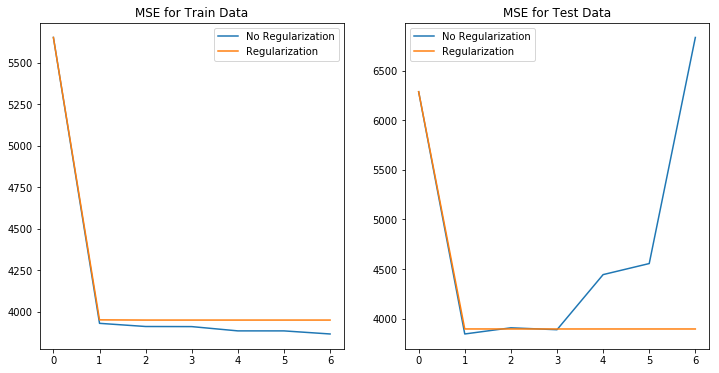

Non-linear Regression with p=1 and lambda=0
  MSE for training data:3930.9154073159016  MSE for test data:3845.034730173414
Non-linear Regression with p=4 and lambda=0.0598
  MSE for training data:3950.5555856847427  MSE for test data:3895.353675253897


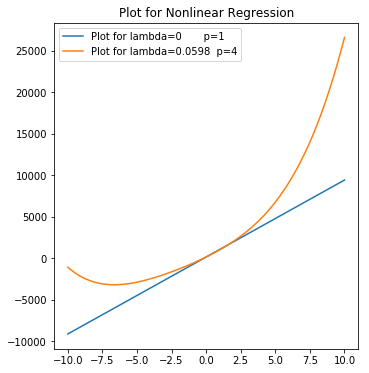

In [18]:
# Problem 5
pmax = 7
#lambda_opt = 0 # REPLACE THIS WITH lambda_opt estimated from Problem 3
lambda_opt = 0.0598 #estimate from Problem 3
mses5_train = np.zeros((pmax,2))
mses5 = np.zeros((pmax,2))
for p in range(pmax):
    Xd = mapNonLinear(X[:,2],p)
    Xdtest = mapNonLinear(Xtest[:,2],p)
    
    w_d1 = learnRidgeRegression(Xd,y,0)
    mses5_train[p,0] = testOLERegression(w_d1,Xd,y)
    mses5[p,0] = testOLERegression(w_d1,Xdtest,ytest)
    
    w_d2 = learnRidgeRegression(Xd,y,lambda_opt)
    mses5_train[p,1] = testOLERegression(w_d2,Xd,y)
    mses5[p,1] = testOLERegression(w_d2,Xdtest,ytest)

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax),mses5_train)
plt.title('MSE for Train Data')
plt.legend(('No Regularization', 'Regularization'))

plt.subplot(1, 2, 2)
plt.plot(range(pmax),mses5)
plt.title('MSE for Test Data')
plt.legend(('No Regularization', 'Regularization'))
plt.show()

print('Non-linear Regression with p='+str(np.argmin(mses5[:,0]))+' and lambda=0')
print('  MSE for training data:'+str(mses5_train[np.argmin(mses5[:,0])][0])+'  MSE for test data:'+str(mses5[np.argmin(mses5[:,0])][0]))

print('Non-linear Regression with p='+str(np.argmin(mses5[:,1]))+' and lambda=0.0598')
print('  MSE for training data:'+str(mses5_train[np.argmin(mses5[:,1])][1])+'  MSE for test data:'+str(mses5[np.argmin(mses5[:,1])][1]))


#Plotting curve for the optimal value of p for both values of λ
lamba = 0
lamba_opt = 0.0598

Xd1 = mapNonLinear(X[:,2],1)
Xd2 = mapNonLinear(X[:,2],4)
    
w_d1 = learnRidgeRegression(Xd1,y,lamba)
w_d2 = learnRidgeRegression(Xd2,y,lambda_opt)

x_plot = np.mat(np.linspace(-10, 10, num=201)).transpose()
X_P = np.concatenate((np.ones((x_plot.shape[0],1)), x_plot), axis=1)
X_P2 = mapNonLinear(np.linspace(-10, 10, num=201),4)

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(x_plot,np.dot(X_P, w_d1))
plt.plot(x_plot,np.dot(X_P2, w_d2))
plt.title('Plot for Nonlinear Regression')
plt.legend(['Plot for lambda=0       p=1','Plot for lambda=0.0598  p=4'])
plt.show()